In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [41]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row=session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11ec3ef98>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
first_row=session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11eccdd30>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [12]:
late_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
late_date

('2017-08-23')

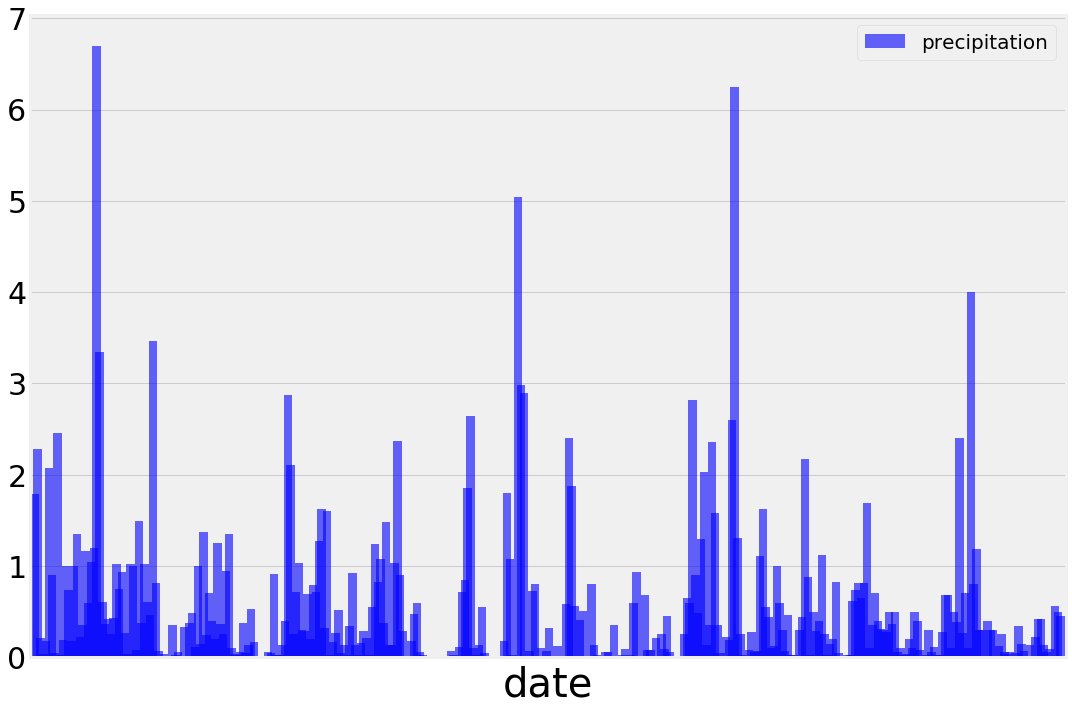

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_year=dt.date(2017, 8, 23)-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
Measurement_last_year=session.query(Measurement.prcp,Measurement.date).filter(Measurement.date>=last_year).\
                                                           order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_last_year=[i[0] for i in Measurement_last_year]
date_last_year=[i[1] for i in Measurement_last_year]
df=pd.DataFrame({"precipitation":prcp_last_year,"date":date_last_year})

# Sort the dataframe by date
df_group=df.groupby('date')
sum_gr=df_group['precipitation'].max()



# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(1,1)
sum_gr.plot(kind="bar",figsize=(15,10),width=3,alpha=0.6,legend=True,color='blue')
ax.grid(axis="x")
ax.set_xticklabels([])
plt.tick_params(axis='y', labelsize=30)
plt.legend(fontsize=20)
ax.set_xlabel("date",fontsize=40)
fig.tight_layout()
plt.show()

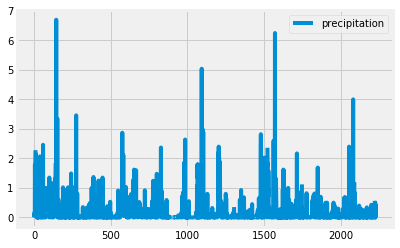

In [14]:
df.plot(x_compat=False)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [17]:
session.query(Measurement.station).distinct().all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                 filter(Measurement.station=='USC00519281').first()

(54.0, 85.0, 71.66378066378067)

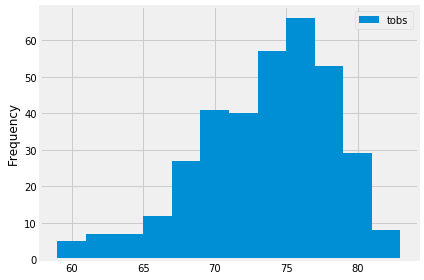

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
x=session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date>=last_year).all()
x_axis=np.ravel(x)
num_bins = 12
fig, ax = plt.subplots(1,1)
ax.hist(x_axis, num_bins, label="tobs")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                   filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
def avg_temps(start_date, end_date):
    return session.query(func.avg(Measurement.tobs)).filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
def max_temps(start_date, end_date):
    return session.query(func.max(Measurement.tobs)).filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
def min_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs)).filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date=dt.date(2018, 1, 1)-dt.timedelta(days=365)
end_date=dt.date(2018, 1, 8)-dt.timedelta(days=365)
temperature = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                   filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
temperature

[(60.0, 68.27659574468085, 74.0)]

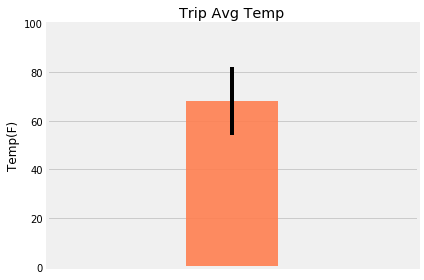

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_axis=temperature[0][1]
fig, ax = plt.subplots(1,1) 
dif=temperature[0][2]-temperature[0][0]
plt.bar(0,height=y_axis,width=0.5,yerr=dif,color='coral',alpha=0.9)
plt.xlim(-1,1)
ax.grid(axis="x")
plt.ylabel("Temp(F)")
plt.ylim(0,100,20)
ax.set_xticklabels([])
plt.title("Trip Avg Temp")
fig.tight_layout()
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation, prcp sum
comb=[Measurement.station,Station.name,Station.latitude, Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
total=session.query(*comb).group_by(Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    filter(Measurement.station==Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
print(total)

[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.63), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.63), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
start_date=dt.date(2017,1,1)
start_date.strftime("%m-%d")

'01-01'

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

start_date=dt.date(2017,1,1)
end_date=dt.date(2017,1,8)

sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
normals=[]
time=[]
dat=start_date
while dat<end_date:
    time.append(dat)
    ref=dat.strftime("%m-%d")
    n=session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == ref).first()
    normals.append(n)
    dat=dat+dt.timedelta(days=1)
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin=[]
tavg=[]
tmax=[]
for i in normals:
    tmin.append(i[0])
    tavg.append(i[1])
    tmax.append(i[2])
df=pd.DataFrame({"tmin":tmin,"tavg":tavg,"tmax":tmax})
df.index=time
df

,tmin,tavg,tmax
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0


In [29]:
df.tmin


2017-01-01    62.0
2017-01-02    60.0
2017-01-03    62.0
2017-01-04    58.0
2017-01-05    56.0
2017-01-06    61.0
2017-01-07    57.0
Name: tmin, dtype: float64

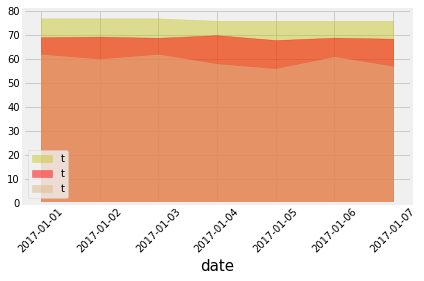

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
x=df.index
y1=df.tmin
y2=df.tavg
y3=df.tmax
labels=["tmin","tavg","tmax"]
fig,ax=plt.subplots()
plt.stackplot(x,y3,color="y", alpha=0.4, labels="tmax")
plt.stackplot(x,y2,color="r",alpha=0.5, labels="tavg")
plt.stackplot(x,y1,color="burlywood",alpha=0.5, labels="tmin")
plt.xticks(rotation=45)
ax.set_xlabel("date",fontsize=15)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

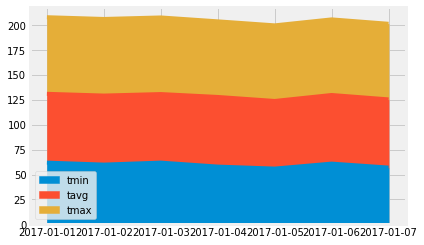

In [31]:
df.plot(kind='area')

<IPython.core.display.Javascript object>


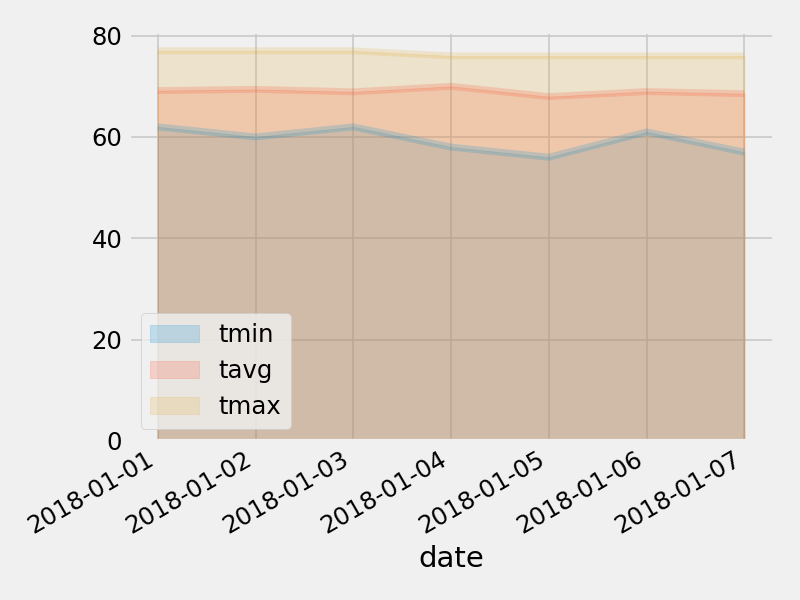